# BMF Project Week 2 
Llan Almendariz (1419951)


In [1]:
import pandas as pd
import numpy as np 
import sklearn.svm as svm 
import sklearn.model_selection as skm
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix, mean_squared_error, accuracy_score, classification_report, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso

In [2]:
f = "ml2023_projectmbf-main/data_labeled_fixed.csv"
f = "../../ml2023/data_labeled_fixed.csv"
exp = pd.read_csv(f, header = 0)

# SVM classification 

In [3]:
# splitting the data 
train, test = skm.train_test_split(exp, random_state=1)
X_train, X_test = train.drop(["CLASS", "CELLTYPE"], axis=1), test.drop(["CLASS", "CELLTYPE"], axis = 1)
Y_train, Y_test = train["CLASS"], test["CLASS"]



In [5]:
# optimizing parameters

clf_opt = clf = svm.SVC(decision_function_shape='ovr')
to_optimize = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['poly']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['sigmoid']}  
 ]

search = skm.GridSearchCV(clf_opt, param_grid=to_optimize,)
find = search.fit(X_train, Y_train)

In [6]:
# turning the optimization results into a dataframe
dfa = pd.DataFrame(find.cv_results_)
dfa.to_csv("gridsearch_svm.csv", index = False)

In [7]:
clf = svm.LinearSVC(dual="auto")
clfit = clf.fit(X_train, Y_train)

In [8]:
def crossval(model, x_test, y_test):
    y_pred = model.predict(x_test)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)

In [10]:
def Kcrossval(data, model, dep, to_remove=[], k=0):
    kf = skm.KFold(n_splits=k)
    splits = kf.split(data)
    
    results = []
    for i, (train, test) in enumerate(splits):
        X_train, Y_train = data.drop(dep, axis =1).drop(to_remove, axis= 1).iloc[train,:], data[dep][train]
        X_test, Y_test = data.drop(dep, axis=1).drop(to_remove, axis = 1).iloc[test, :], data[dep][test]
        
        model = model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        
        if Y_test.dtype != int:
            #results.append(accuracy_score(Y_test, Y_pred))
            results.append(classification_report(Y_test, Y_pred, target_names=model.classes_, output_dict = True))
        else:
            results.append(mean_squared_error(Y_test, Y_pred))
            
    
    return np.array(results)

In [11]:
clf.classes_

array(['Amacrine', 'Cone Bipolar OFF', 'Cone Bipolar ON', 'Rod Bipolar'],
      dtype=object)

In [12]:
report = Kcrossval(exp, clf, "CLASS", ["CELLTYPE"], 5)

In [13]:
dfs = []
for entry in report:
    dfs.append(pd.DataFrame(entry))

In [14]:
mat3d = np.array([df.values for df in dfs])

In [15]:
pd.DataFrame(np.mean(mat3d, axis=0), columns = dfs[0].columns, index = dfs[0].index).to_csv("SVM_classification.csv")

In [16]:
pd.DataFrame(np.mean(mat3d, axis=0), columns = dfs[0].columns, index = dfs[0].index)

,Amacrine,Cone Bipolar OFF,Cone Bipolar ON,Rod Bipolar,accuracy,macro avg,weighted avg
precision,0.980000,0.990777,0.986543,0.970724,0.987378,0.982011,0.987461
recall,0.982078,0.991647,0.984607,0.979970,0.987378,0.984575,0.987378
f1-score,0.980263,0.991196,0.985564,0.975220,0.987378,0.983060,0.987375
support,25.800000,331.600000,287.400000,100.000000,0.987378,744.800000,744.800000


# SVM Regression

In [17]:
# function to convert the R2 to adjusted R2
Adj_r2 = lambda r_2, n, p: 1 - (1-r_2) * (n-1)/(n-p-1)

In [18]:
# prepate data

X_calm, Y_calm = exp.drop(["CLASS", "CELLTYPE", "Calm1"], axis=1), exp["Calm1"]

Xc_train, Xc_test, Yc_train, Yc_test = skm.train_test_split(X_calm, Y_calm,random_state=1)

In [19]:
clf_regr = svm.SVR()
to_optimize = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['poly']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['sigmoid']}  
 ]

search = skm.GridSearchCV(clf_opt, param_grid=to_optimize,)
find = search.fit(Xc_train, Yc_train)

/home/llan/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [20]:
df_r = pd.DataFrame(find.cv_results_).sort_values("rank_test_score")
df_r.to_csv("SVR_gridsearch.csv", index = False)

In [21]:
# defining and fitting the model 
svr = svm.SVR(kernel="rbf", C=1, gamma=0.001)

svr_fit = svr.fit(Xc_train, Yc_train)

In [22]:
# predicting on the test set
Yc_pred = svr_fit.predict(Xc_test)

In [23]:
res = Kcrossval(exp, svr, "Calm1", ["CELLTYPE", "CLASS"], 5)

In [24]:
r2 = r2_score(Yc_test, Yc_pred)

In [25]:
print(f"SVM regression adjusted R squared: {Adj_r2(r2, len(Yc_test), Xc_test.shape[1])}")

SVM regression adjusted R squared: 0.2561935299744579


In [26]:
print(f"mean MSE over k = 5 crossvalidation {res.mean()}")

mean MSE over k = 5 crossvalidation 37.60446251146868


# Lasso Regression

In [27]:
def iter_lasso(alphas, data, fulldata):
    res = []
    kvals = []
    for a in alphas:
        X, Y = data
        clf_lasso = Lasso(alpha=a)
        clf_lasso.fit(X, Y)
        res.append(clf_lasso.coef_)
        kval = Kcrossval(fulldata, clf_lasso, "Calm1", ["CELLTYPE", "CLASS"], 5).mean()
        kvals.append(kval)
    matrix = np.vstack(res)
    df = pd.DataFrame(matrix, index=alphas, columns = clf_lasso.feature_names_in_)
    df["kval"] = kvals
    return df

In [28]:
df_l = iter_lasso(np.arange(0.1, 35,0.1), (Xc_train, Yc_train), fulldata=exp)

In [29]:
df_l

,Acin1,Actb,Agap1,Ahi1,Akap11,Akap9,Aldoa,Aldoc,Ankrd12,Anp32a,...,Zranb2,mt-Co1,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd4,mt-Nd5,mt-Rnr1,mt-Rnr2,kval
0.1,-0.0,0.06183,-0.0,-0.0,-0.050196,0.0,0.052767,-0.0,-0.0,0.017363,...,-0.0,-0.070034,-0.0,0.042140,-0.0,0.000155,-0.0,-0.0,0.007885,24.507716
0.2,-0.0,0.00000,-0.0,-0.0,-0.000000,0.0,0.000000,-0.0,-0.0,0.002790,...,-0.0,-0.000000,-0.0,0.047810,-0.0,0.000000,-0.0,-0.0,0.009902,25.059400
0.3,-0.0,0.00000,-0.0,-0.0,-0.000000,0.0,0.000000,-0.0,-0.0,0.000000,...,-0.0,-0.000000,0.0,0.050560,-0.0,0.000000,0.0,-0.0,0.010947,25.922432
0.4,-0.0,0.00000,-0.0,-0.0,-0.000000,0.0,0.000000,-0.0,-0.0,0.000000,...,0.0,-0.000000,0.0,0.045051,-0.0,0.000000,0.0,-0.0,0.010844,26.732172
0.5,-0.0,0.00000,-0.0,-0.0,-0.000000,0.0,0.000000,-0.0,-0.0,0.000000,...,0.0,-0.000000,0.0,0.035805,-0.0,0.000000,0.0,-0.0,0.010383,27.523429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34.5,-0.0,0.00000,0.0,0.0,-0.000000,-0.0,-0.000000,-0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,95.868415
34.6,-0.0,0.00000,0.0,0.0,-0.000000,-0.0,-0.000000,-0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,95.921009
34.7,-0.0,0.00000,0.0,0.0,-0.000000,-0.0,-0.000000,-0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,95.973781
34.8,-0.0,0.00000,0.0,0.0,-0.000000,-0.0,-0.000000,-0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,96.026732


In [30]:
mse = df_l[["kval"]]
df_l = df_l.drop("kval", axis = 1)

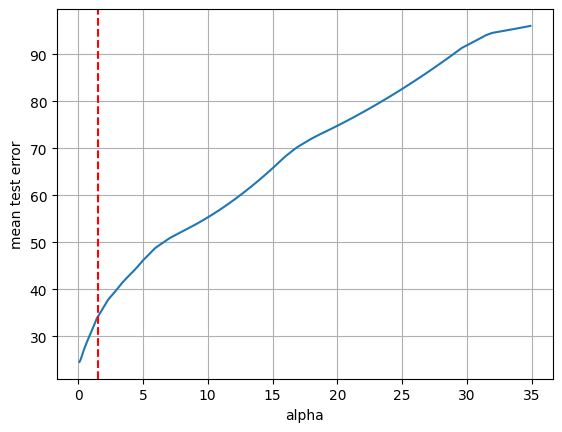

In [31]:
sns.lineplot(data=mse,x=mse.index, y="kval")
plt.axvline(1.5, color = "r", linestyle="--")
plt.xlabel("alpha")
plt.ylabel("mean test error")
plt.grid()
plt.savefig("mean_test_error_lasso.png", dpi = 350)

In [32]:
keep = df_l.columns[df_l.iloc[14] != 0]

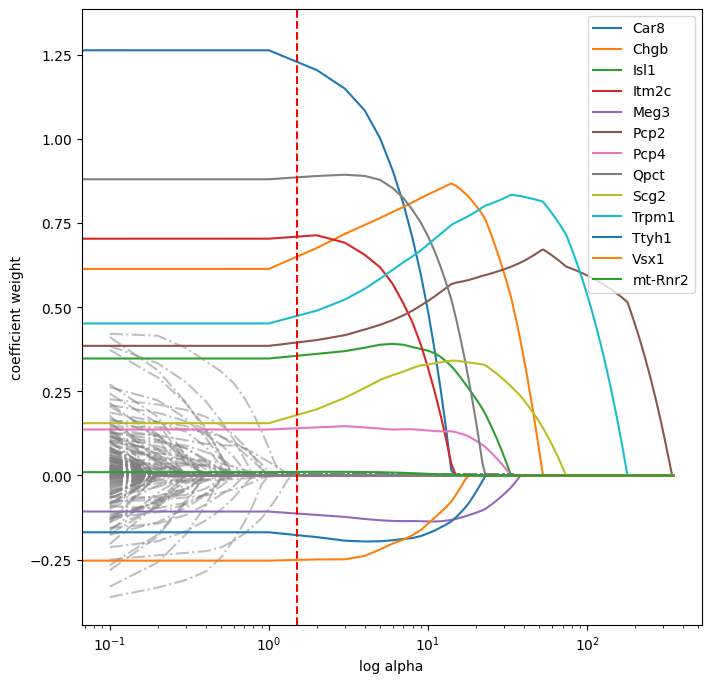

In [33]:
fig, axes = plt.subplots(1,1, figsize=(8,8))

for col in df_l:
    if col in keep:
        axes.plot(df_l[col].values, label=col)

    else:
        axes.plot(df_l[col], color = "grey", linestyle="-.", alpha=0.5)
axes.axvline(1.5, color = "red", linestyle="--")
axes.set_xscale("log")
axes.set_xlabel("log alpha")
axes.set_ylabel("coefficient weight")
axes.legend(loc = "upper right")
plt.savefig("tuning_alpha_lasso.png", dpi = 350)

In [34]:
clf_lasso = Lasso(alpha=1.5)
clf_lasso.fit(Xc_train, Yc_train)

Lasso(alpha=1.5)

In [35]:
foi = pd.DataFrame(df_l[keep].iloc[14])

In [36]:
foi = foi.rename(columns = {foi.columns[0]: "coefficients"})
foi = foi.sort_values("coefficients")

In [37]:
foi.to_csv("features_of_interest_lasso.csv")

In [38]:
foi

,coefficients
Ttyh1,-0.136228
Meg3,-0.131975
Vsx1,-0.077760
mt-Rnr2,0.002795
Car8,0.014755
Itm2c,0.034599
Pcp4,0.131542
Isl1,0.324766
Scg2,0.341114
Qpct,0.523419


In [39]:
Yc_pred = clf_lasso.predict(Xc_test)

In [40]:
r2 = r2_score(Yc_test, Yc_pred)

In [41]:
print(f"Lasso' adjusted R squared: {Adj_r2(r2, len(Yc_test), 12)}")

Lasso' adjusted R squared: 0.6220876133391422


In [42]:
print(f"mean MSE over k = 5 cross validations: {mse.iloc[14].values}")

mean MSE over k = 5 cross validations: [34.04074959]


# Identifying Features

In [43]:
def f_importances(coef, names, i, j, axes, name, color):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    names = names[:11] + names[-11:]
    imp = imp[:11] + imp[-11:] 
    axes[i,j].barh(range(len(names)), imp, align='center', color = color)
    axes[i,j].set_yticks(range(len(names)), names)
    axes[i,j].set_title("Class: " + name)
    axes[i,j].xaxis.grid()



In [44]:
n = np.matrix("1 2; 3 4")

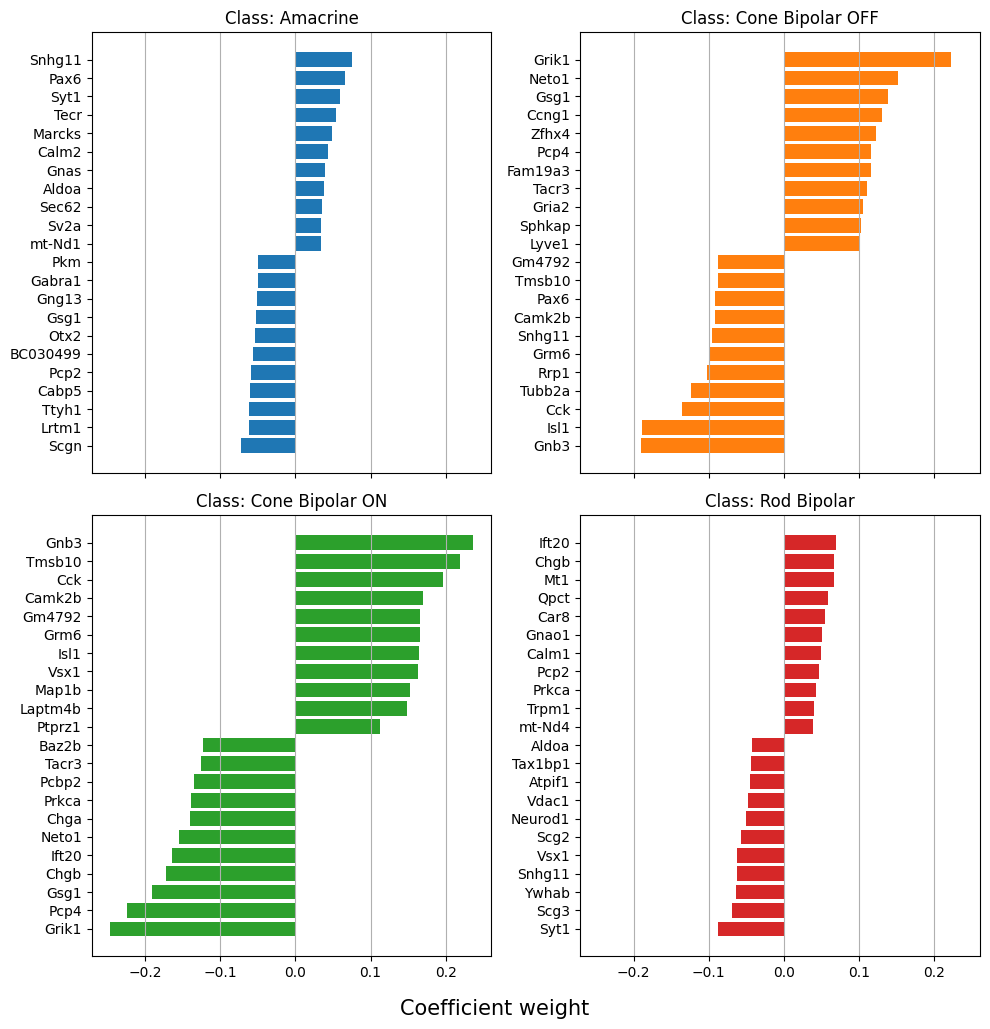

In [45]:
# features from the SVC

fig, axes = plt.subplots(2, 2, figsize = (10, 10),sharex=True)
fig.tight_layout()
ii= 0
colors = sns.color_palette()
for i in range(0,2):
    for j in range(0,2):
        
        name = clfit.classes_[ii]
        f_importances(clfit.coef_[ii],  clfit.feature_names_in_, i, j, axes, name, colors[ii])
        ii +=1


fig.text(0.5, -0.02, 'Coefficient weight', ha='center', size = 15)
fig.tight_layout()
plt.savefig("SVM_class_coefficients.png", dpi = 350, bbox_inches = "tight")

# Session info

In [46]:
import session_info

In [47]:
session_info.show()